# FGMC Benchmark Volatility Modelling & Forecasting
* Time Series Analysis based on Garch(p,q) fitting
* Generating forecasting model based on in sample data
* Backtesting model prediction based on out of sample data

In [71]:
import numpy as np
import pandas as pd
from scipy import optimize
import statistics as st
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [72]:
df = pd.read_csv('data.csv', index_col = 'Date', parse_dates = True)
df[-5:]

,GN2 3.5
Date,
2016-08-08,106.109375
2016-08-09,106.296875
2016-08-10,106.328125
2016-08-11,106.171875
2016-08-12,106.226562


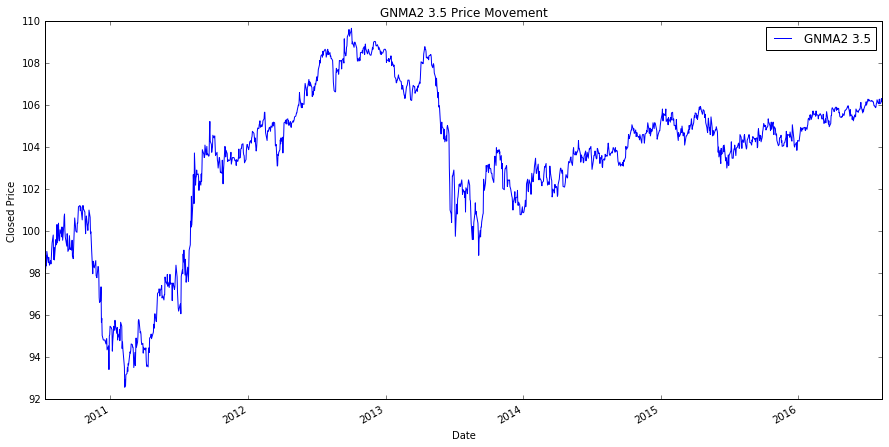

In [73]:
data = df['GN2 3.5']

plt.figure(figsize=(15,7.5))
plt.title('GNMA2 3.5 Price Movement')
plt.xlabel('Date')
plt.ylabel('Closed Price')
data.plot(label='GNMA2 3.5')
plt.legend()
plt.show(block=False)

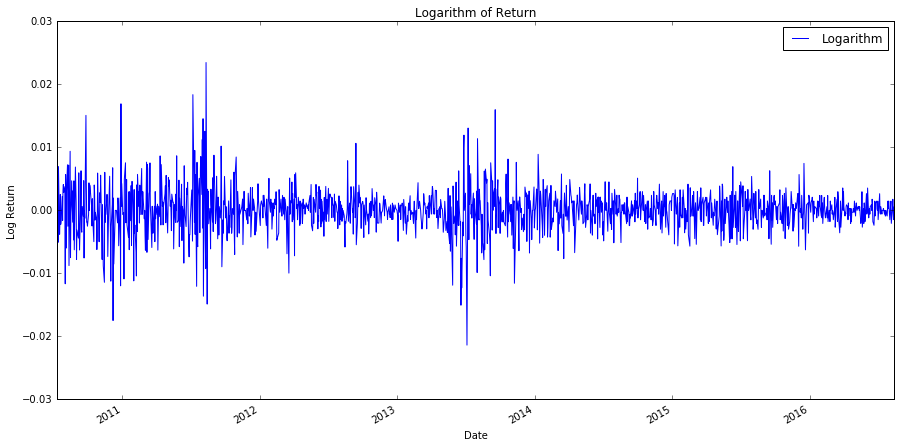

In [74]:
r = np.log(data / data.shift(1))
data.dropna()

plt.figure(figsize=(15,7.5))
plt.title('Logarithm of Return')
plt.xlabel('Date')
plt.ylabel('Log Return')
r.plot(label='Logarithm')
plt.legend()
plt.show(block=False)

In [75]:
def GARCH11_logL(param, r):
    omega, alpha, beta = param
    n = len(r)
    s = np.ones(n)*0.01
    s[2] = st.variance(r[0:3])
    for i in range(3, n):
        s[i] = omega + alpha*r[i-1]**2 + beta*(s[i-1])  # GARCH(1,1) model
    logL = -((-np.log(s) - r**2/s).sum())
    return logL

In [76]:
return_ = r.dropna()
return_ = return_.values
o = optimize.fmin(GARCH11_logL,np.array([.1,.1,.1]), args=(return_,), full_output=1)

Optimization terminated successfully.
         Current function value: -15919.528719
         Iterations: 83
         Function evaluations: 162


In [77]:
R = np.abs(o[0])
print("omega = %.6f\nbeta  = %.6f\nalpha = %.6f\n" % (R[0], R[2], R[1]))

omega = 0.000007
beta  = 0.120372
alpha = 0.130501



In [78]:
#Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

In [79]:
sigma_hats = np.sqrt(compute_squared_sigmas(return_, np.sqrt(np.mean(return_**2)), R))
initial_sigma = sigma_hats[-1]
initial_sigma

0.0029606406331336424

In [80]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # Initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
        
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    
    return X, sigma

In [85]:
a0_estimate = R[0]
a1_estimate = R[1]
b1_estimate = R[2]

X, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)
X_ = np.exp(X)

predict_price = np.ndarray(100)
predict_price[0] = df[-1:].values
for i in range(1,100):
    predict_price[i] = predict_price[i-1] * X_[i-1]

Starting Point is:

               GN2 3.5
Date                  
2016-08-12  106.226562


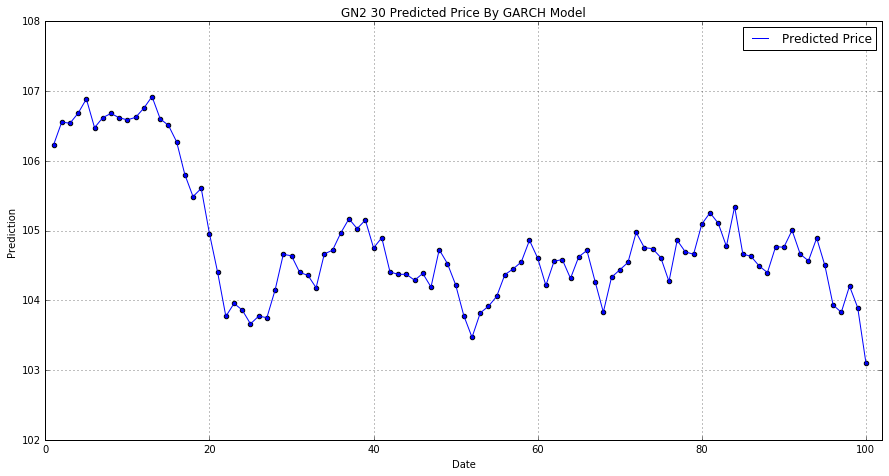

In [86]:
print("Starting Point is:\n")
print(df[-1:])

plt.figure(figsize=(15,7.5))
plt.title('GN2 30 Predicted Price By GARCH Model')
plt.xlabel('Date')
plt.ylabel('Prediction')
pylab.xlim([0,102])
plt.grid(True)
plt.scatter(range(1,101),predict_price)
plt.plot(range(1,101),predict_price, label = 'Predicted Price')
plt.legend()
plt.show(block=False)

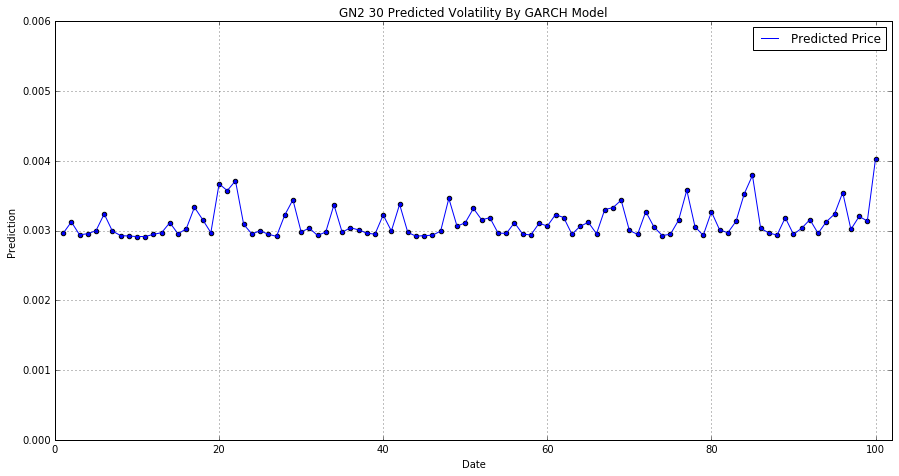

In [90]:
plt.figure(figsize=(15,7.5))
plt.title('GN2 30 Predicted Volatility By GARCH Model')
plt.xlabel('Date')
plt.ylabel('Prediction')
pylab.xlim([0,102])
pylab.ylim([0,0.006])
plt.grid(True)
plt.scatter(range(1,101),sigma_forecast)
plt.plot(range(1,101),sigma_forecast, label = 'Predicted Price')
plt.legend()
plt.show(block=False)